In [1]:
import rasterio as rio
from cmr import CollectionQuery, GranuleQuery

import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon

import ipywidgets as widgets
import matplotlib.pyplot as plt
import cartopy.crs as ccrs 
import cartopy.io.img_tiles as cimgt

import requests
import os
from tqdm import tqdm 
import math

import subprocess

# Step 1: ASO Acqusition ❄️ ✈️ 🖥 ❄
 

This notebook represents the first step of the Planet SCA data pipeline to set up for model training. Each instance of model training is based around ASO collects in a single region, which forms the basis for the imagery which is used to train the model (described in Step 2: Planet Ordering). 

The steps to complete this process are as follows: 

1. Query the NASA Common Metadata Repository (CMR) for Airborne Snow Observatory (ASO) collects. 
1. Select ASO collect **region**. 
1. Filter CMR results to selected region. 
1. Select ASO collects based on collection date for given region. 
1. Download data from NSIDC DAAC. 
1. Process ASO collect (thresholding, creation of spatial footprint) 
1. Store raw and processed ASO collects in S3. 
1. Tile processed collects and upload to S3.
 
⚠️ **Requirements** ⚠️

1. This notebook must be run with a version of the `pytorch_p36` conda environment (we'll check this)
2. You need an account with NASA Earthdata. Create one [here](https://urs.earthdata.nasa.gov/users/new). 
3. You need at least 5GB of free space available on this computer's storage. 
4. You need to have configured your AWS Command Line tools described [here](https://docs.aws.amazon.com/cli/latest/userguide/cli-chap-configure.html) via `aws configure`, and know the "profile name" of your chosen profile, if you have multiple.
5. You also need to have configured an AWS S3 Bucket to store these resulting images and their tiled versions.

In [59]:
assert "pytorch_p36" in os.environ['CONDA_DEFAULT_ENV'], "Need to activate pytorch_p36 environment"

## ASO Catalog Search 🔎

Below we use the NASA CMR to search for ASO collects.

In [2]:
# Load the ASO Catalog
nasaAPI = GranuleQuery()
aso = pd.DataFrame(nasaAPI.short_name('ASO_3M_SD').get())
aso.head()

,producer_granule_id,time_start,updated,dataset_id,data_center,title,coordinate_system,day_night_flag,time_end,id,original_format,granule_size,browse_flag,polygons,collection_concept_id,online_access_flag,links
0,ASO_3M_SD_USCATB_20130403.tif,2013-04-03T00:00:00.000Z,2019-07-09T14:43:15.619Z,ASO L4 Lidar Snow Depth 3m UTM Grid V001,NSIDC_ECS,SC:ASO_3M_SD.001:162848623,GEODETIC,UNSPECIFIED,2013-04-03T23:59:59.000Z,G1623914151-NSIDC_ECS,ECHO10,309.929,False,[[37.72826 -119.78855 37.74097 -119.18652 38.1...,C1521188702-NSIDC_ECS,True,[{'rel': 'http://esipfed.org/ns/fedsearch/1.1/...
1,ASO_3M_SD_USCATB_20130429.tif,2013-04-29T00:00:00.000Z,2019-07-09T14:44:30.639Z,ASO L4 Lidar Snow Depth 3m UTM Grid V001,NSIDC_ECS,SC:ASO_3M_SD.001:162848651,GEODETIC,UNSPECIFIED,2013-04-29T23:59:59.000Z,G1623914238-NSIDC_ECS,ECHO10,1133.05,False,[[37.72826 -119.78855 37.74097 -119.18652 38.1...,C1521188702-NSIDC_ECS,True,[{'rel': 'http://esipfed.org/ns/fedsearch/1.1/...
2,ASO_3M_SD_USCATB_20130503.tif,2013-05-03T00:00:00.000Z,2019-07-09T14:44:00.613Z,ASO L4 Lidar Snow Depth 3m UTM Grid V001,NSIDC_ECS,SC:ASO_3M_SD.001:162848643,GEODETIC,UNSPECIFIED,2013-05-03T23:59:59.000Z,G1623914198-NSIDC_ECS,ECHO10,1133.05,False,[[37.72826 -119.78855 37.74097 -119.18652 38.1...,C1521188702-NSIDC_ECS,True,[{'rel': 'http://esipfed.org/ns/fedsearch/1.1/...
3,ASO_3M_SD_USCATB_20130525.tif,2013-05-25T00:00:00.000Z,2019-07-09T14:44:15.633Z,ASO L4 Lidar Snow Depth 3m UTM Grid V001,NSIDC_ECS,SC:ASO_3M_SD.001:162848650,GEODETIC,UNSPECIFIED,2013-05-25T23:59:59.000Z,G1623914214-NSIDC_ECS,ECHO10,1133.05,False,[[37.72826 -119.78855 37.74097 -119.18652 38.1...,C1521188702-NSIDC_ECS,True,[{'rel': 'http://esipfed.org/ns/fedsearch/1.1/...
4,ASO_3M_SD_USCATB_20130601.tif,2013-06-01T00:00:00.000Z,2019-07-09T14:44:00.636Z,ASO L4 Lidar Snow Depth 3m UTM Grid V001,NSIDC_ECS,SC:ASO_3M_SD.001:162848644,GEODETIC,UNSPECIFIED,2013-06-01T23:59:59.000Z,G1623914150-NSIDC_ECS,ECHO10,1133.05,False,[[37.72826 -119.78855 37.74097 -119.18652 38.1...,C1521188702-NSIDC_ECS,True,[{'rel': 'http://esipfed.org/ns/fedsearch/1.1/...


In [3]:
## Parse into Useful Data

# Parse dates for easier sorting
aso.time_start = pd.to_datetime(aso.time_start)

# Store ASO region
aso['aso_region'] = [granId.split('_')[3] for granId in aso.producer_granule_id]

# Convert polygons into Shapely Polygons.
polygons = []
for raw_poly in aso.polygons.values:
    t = pd.to_numeric(raw_poly[0][0].split(" "))
    polygons.append(Polygon(list(zip(t[1::2], t[::2]))))
aso['geom'] = polygons

In [4]:
# Compute ASO region area. 
aso['area'] = [_g.area for _g in polygons]

In [5]:
# Examine ASO regions by area. 

asoRegions = sorted(aso.aso_region.unique())
asoRegions = list(zip(["{}-{:.2f}".format(a[0], a[1]) for a in zip(asoRegions, ([aso[aso.aso_region == a].area.min() for a in asoRegions]))], asoRegions))
asoRegions

[('USCAJW-0.98', 'USCAJW'),
 ('USCAKC-0.55', 'USCAKC'),
 ('USCAKN-0.55', 'USCAKN'),
 ('USCALB-0.01', 'USCALB'),
 ('USCALV-0.03', 'USCALV'),
 ('USCAMB-0.15', 'USCAMB'),
 ('USCARC-0.03', 'USCARC'),
 ('USCARL-0.00', 'USCARL'),
 ('USCASF-0.98', 'USCASF'),
 ('USCASJ-0.98', 'USCASJ'),
 ('USCATB-0.27', 'USCATB'),
 ('USCATE-0.37', 'USCATE'),
 ('USCOCB-0.09', 'USCOCB'),
 ('USCOCJ-0.21', 'USCOCJ'),
 ('USCOGE-0.25', 'USCOGE'),
 ('USCOGM-0.39', 'USCOGM'),
 ('USCOGT-0.22', 'USCOGT'),
 ('USCORG-0.63', 'USCORG'),
 ('USWAOL-0.62', 'USWAOL')]

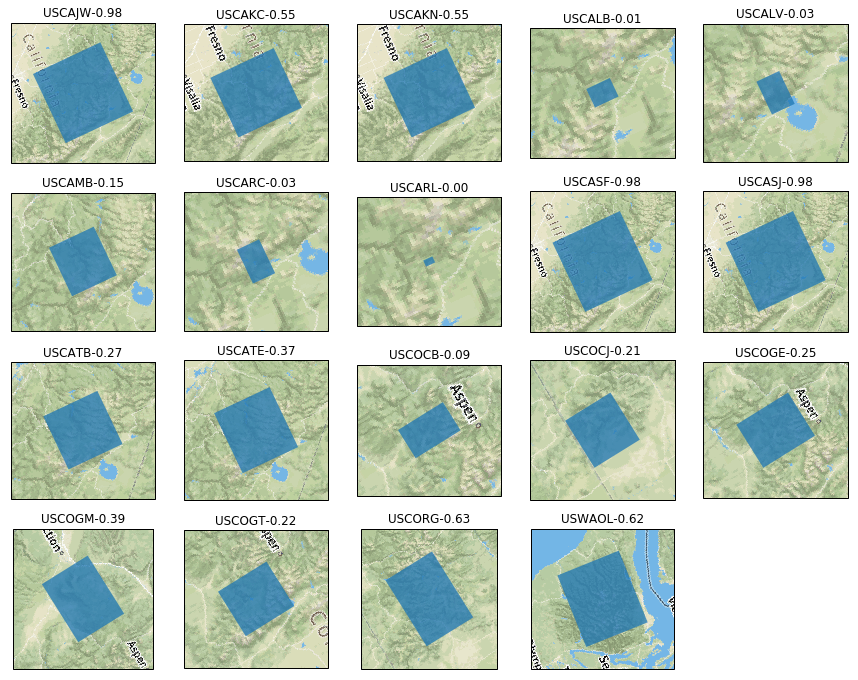

In [69]:
## Create figure of all ASO regions. 
## NOTE: This takes ~2-3 minutes to complete.
##       If there's already a figure below this cell, there's no need to run it. 

fig = plt.figure(figsize=(15, 15))
gs = plt.GridSpec(5, 5)

mapbox = cimgt.MapboxTiles(
    access_token="pk.eyJ1IjoiYWNhbm5pc3RyYSIsImEiOiJLWVM2RWhJIn0.TputXxRYBUPh-vjDg6_TFA", 
    map_id = 'streets'
)


for i, region in enumerate(asoRegions):
    geom = aso[aso.aso_region == region[1]].geom.values[0]
    _a = plt.subplot(gs[i], projection=ccrs.AlbersEqualArea())
    _a.get_xaxis().set_visible(False)
    _a.get_yaxis().set_visible(False)
    _a.add_geometries([geom], crs=ccrs.PlateCarree(), alpha=0.76)
    _a.set_title("{}-{:.2f}".format(region[1], geom.area))
    bds = geom.buffer(0.2).bounds
    _a.set_extent([bds[0], bds[2], bds[1], bds[3]], crs = ccrs.PlateCarree())
    _a.add_image(mapbox, 7)
    

## Select ASO Region 

Choose a focal ASO region to examine collects. 

In [6]:
region = widgets.Dropdown(
    options=asoRegions,
    description='ASO Region:',
    disabled=False,
)
region

Dropdown(description='ASO Region:', options=(('USCAJW-0.98', 'USCAJW'), ('USCAKC-0.55', 'USCAKC'), ('USCAKN-0.…

In [7]:
region.value = 'USCOGE'

## Select ASO Candidates for Selected Region 

Choose ASO collects for selected region. 

In [37]:
regionalCandidates = aso[
    (aso.aso_region == region.value) 
]

In [38]:
options = list(zip(regionalCandidates.time_start, regionalCandidates.producer_granule_id))
granuleSelector = widgets.SelectMultiple(
    options= options,
    rows=10,
    description='{}'.format(region.value),
    disabled=False
)
granuleSelector

SelectMultiple(description='USCATB', options=((Timestamp('2013-04-03 00:00:00+0000', tz='UTC'), 'ASO_3M_SD_USC…

In [40]:
filename = granuleSelector.value

## Download Data 🖥

We'll build up the correct URLs for the selected ASO assets and download them via cURL from Earthdata. 

In [41]:
regionalCandidates[regionalCandidates.producer_granule_id.isin(filename)].links

5    [{'rel': 'http://esipfed.org/ns/fedsearch/1.1/...
Name: links, dtype: object

In [42]:
downloadTo = '/tmp/work/'

In [43]:
urls = [l[0]['href'] for l in regionalCandidates[
    regionalCandidates.producer_granule_id.isin(filename)].links
]

In [44]:
! mkdir /tmp/work

mkdir: cannot create directory ‘/tmp/work’: File exists


In [45]:
urls

['https://n5eil01u.ecs.nsidc.org/DP1/ASO/ASO_3M_SD.001/2013.06.08/ASO_3M_SD_USCATB_20130608.tif']

### Configure cURL to connect with NASA Earthdata Databases. 

⚠️ This requires the environment variables **`EARTHDATA_USERNAME`** and **`EARTHDATA_PASSWORD`** to be set, as described above. 

In [46]:
username = os.environ['EARTHDATA_USERNAME']
password = os.environ['EARTHDATA_PASSWORD']

! echo "machine urs.earthdata.nasa.gov login {username} password {password}" > ~/.netrc && chmod 0600 ~/.netrc
! touch .urs_cookies

In [47]:

for url in urls:    
#     download_file(url, downloadTo, username, password)
    !(cd {downloadTo} &&  curl -O -b ~/.urs_cookies -c ~/.urs_cookies -L -n {url})

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1133M  100 1133M    0     0  10.8M      0  0:01:44  0:01:44 --:--:-- 11.2M798k 0:01:22  0:00:23 11.1M


In [52]:
os.listdir(downloadTo)

['ASO_3M_SD_USCOGE_20180331.tif', 'ASO_3M_SD_USCATB_20130608.tif']

## Preprocess for Tiling

The raw ASO Collect(s) have to be thresholded to a binary raster and their footprints calculated and saved for imagery acqusition. We use the `/preprocess` module for this. 

In [90]:
og_dir = os.getcwd()

for url in urls:
    imgPath = os.path.join(downloadTo, url.split('/')[-1])
    try:
        os.chdir("/home/ubuntu/planet-snowcover/")
        subprocess.check_call(['/home/ubuntu/anaconda3/envs/pytorch_p36/bin/python', '-m', 'preprocess', 'gt_pre', '--gt_file', imgPath, downloadTo, '--footprint', '--threshold', '0.1'])
    except Exception as e: 
        print(e)

In [88]:
# check result
os.listdir(downloadTo)

['ASO_3M_SD_USCOGE_20180331.tif',
 'ASO_3M_SD_USCATB_20130608.tif',
 'ASO_3M_SD_USCATB_20130608.geojson',
 'planet_ids.csv',
 'ASO_3M_SD_USCATB_20130608_binary.tif']

## Upload to Cloud Storage 

After preprocessing the raw ASO collects, we want to add them to a cloud storage bucket so that we can access them later. We're going to use the Amazon **S**imple **S**torage **S**ervice (S3) to do this. 

Specify your AWS Command Line Tools profile and the destination S3 Bucket below:


In [74]:
awsProfile = widgets.Text(description='AWS Profile', value="esip")
awsProfile

Text(value='esip', description='AWS Profile')

In [73]:
awsBucket = widgets.Text(description="S3 Bucket", value='planet-snowcover-snow')
awsBucket

Text(value='planet-snowcover-snow', description='S3 Bucket')

In [81]:
awsUploadCommand = "aws s3 --profile {} sync {} s3://{}".format(awsProfile.value, downloadTo, awsBucket.value)
print(awsUploadCommand)

aws s3 --profile esip sync /tmp/work/ s3://planet-snowcover-test


**🚨 IMPORTANT 🚨:** To avoid over-uploading files to your S3 bucket (+ potentially incurring unnecessary costs), we will perform a "dry run" of this S3 command to verify accuracy. Check it below. If there are extraneous files, remove them from the directory specified by `downloadTo`. 

In [82]:
! {awsUploadCommand + ' --dryrun'}

(dryrun) upload: ../../../tmp/work/ASO_3M_SD_USCATB_20130608.geojson to s3://planet-snowcover-test/ASO_3M_SD_USCATB_20130608.geojson
(dryrun) upload: ../../../tmp/work/ASO_3M_SD_USCATB_20130608.tif to s3://planet-snowcover-test/ASO_3M_SD_USCATB_20130608.tif
(dryrun) upload: ../../../tmp/work/ASO_3M_SD_USCATB_20130608_binary.tif to s3://planet-snowcover-test/ASO_3M_SD_USCATB_20130608_binary.tif
(dryrun) upload: ../../../tmp/work/ASO_3M_SD_USCOGE_20180331.tif to s3://planet-snowcover-test/ASO_3M_SD_USCOGE_20180331.tif


Look OK? Run the below command to perform the upload. 

In [83]:
! {awsUploadCommand}

upload: ../../../tmp/work/ASO_3M_SD_USCATB_20130608.geojson to s3://planet-snowcover-test/ASO_3M_SD_USCATB_20130608.geojson
upload: ../../../tmp/work/ASO_3M_SD_USCATB_20130608_binary.tif to s3://planet-snowcover-test/ASO_3M_SD_USCATB_20130608_binary.tif
upload: ../../../tmp/work/ASO_3M_SD_USCOGE_20180331.tif to s3://planet-snowcover-test/ASO_3M_SD_USCOGE_20180331.tif
upload: ../../../tmp/work/ASO_3M_SD_USCATB_20130608.tif to s3://planet-snowcover-test/ASO_3M_SD_USCATB_20130608.tif


Confirm upload by listing contents of bucket:

In [84]:
! aws s3 --profile {awsProfile.value} ls {awsBucket.value}

2019-10-21 21:49:01        250 ASO_3M_SD_USCATB_20130608.geojson
2019-10-21 21:49:01 1188091675 ASO_3M_SD_USCATB_20130608.tif
2019-10-21 21:49:01  594113058 ASO_3M_SD_USCATB_20130608_binary.tif
2019-10-21 21:49:01  727711744 ASO_3M_SD_USCOGE_20180331.tif


 👌
 
 ---
by Tony Cannistra.

© University of Washington, 2019.

Support from the National Science Foundation, NASA THP, Earth Science Information partners, and the UW eScience Institute.</small>